(50000, 784)


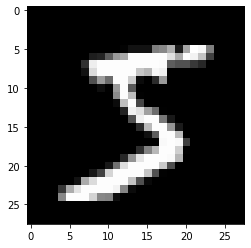

In [1]:
from pathlib import Path
import pickle
from matplotlib import pyplot

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
FILENAME = "mnist.pkl"

with open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [2]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [3]:
import math
from torch.utils.data import TensorDataset
from torch import nn

In [4]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [5]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [6]:
import torch.nn.functional as F
from torch.utils.data import DataLoader

loss_func = F.cross_entropy

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

bs = 64  # batch size

In [7]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [16]:
import numpy as np
import time

lr = 0.1  # learning rate
epochs = 20  # how many epochs to train for

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    loss = []
    start = time.time()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        loss.append(val_loss)
        print(epoch, val_loss)
    print('Time Taken:{0:.4f}s'.format(time.time()-start))
    return loss

In [52]:
from torch import optim

def get_model(optimizer):
    model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
    if optimizer == "ADAM":
        opt = optim.Adam(model.parameters(), lr=4e-3, weight_decay=3e-3)
    else:
        opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    return model, opt

In [55]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model("ADAM")
adam_losses = fit(epochs, model, loss_func, opt, train_dl, valid_dl)
model, opt = get_model("SGD")
sgd_losses = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.9677664869308472
1 0.9162545469284058
2 0.8736978009223938
3 0.8773767872810364
4 0.8428988442420959
5 0.8631816621780396
6 0.8547738968849182
7 0.8124741451263428
8 0.8325116744995117
9 0.8232023689270019
10 0.8151042801856995
11 0.8019002199172973
12 0.8176697225570678
13 0.8030452721595764
14 0.7963104900360107
15 0.8036547993659973
16 0.7923917247772216
17 0.7968482069015503
18 0.8025271327018738
19 0.7896558145523072
Time Taken:126.2462s
0 0.35537261493206024
1 0.23066413054466248
2 0.21083749081492423
3 0.17645405189990998
4 0.15153697116971016
5 0.14124519527554513
6 0.1225981486737728
7 0.12402580758929252
8 0.15322792049348355
9 0.12577505114972592
10 0.127972889322415
11 0.11087520983219147
12 0.11756712114177645
13 0.13844413947761058
14 0.11121941787451506
15 0.11513547008782625
16 0.10269406140781939
17 0.0993511313278228
18 0.10704021633081139
19 0.11365683418214322
Time Taken:97.7834s


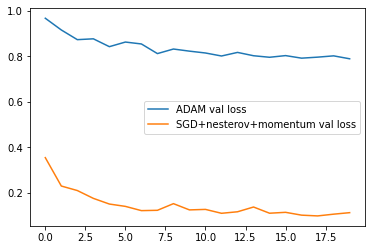

In [56]:
x = [x for x in range(epochs)]
pyplot.plot(x, adam_losses, label="ADAM val loss")
pyplot.plot(x, sgd_losses, label="SGD+nesterov+momentum val loss")
pyplot.legend()